# Micrograd 🔧

> Spelled-out intro to neural networks and backpropagation
 
- toc: false
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter, kaggle]

### A blog implementation of Andrej Karpathy's [micrograd video](https://www.youtube.com/watch?v=VMj-3S1tku0) 
### Work in progress will continually add to this blog

**Content:**
1. [Derivative of a function](#1)
1. [Core Value Object](#2)
1. [Manual Backpropagation](#3)
1. [Backward function](#4)
1. [More operations](#5)
1. [Pytorch](#6)

<a id=1></a>
# Lets get an intuitive understanding of what a derivative is

In [1]:
#basic imports
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Lets use a simple quadratic function as an example <br />
<br/>
## $f(x) = 3x^2 - 4x + 5$


In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

Take a look at the shape of the function, we can expect a parabola since we know its a quadratic function 

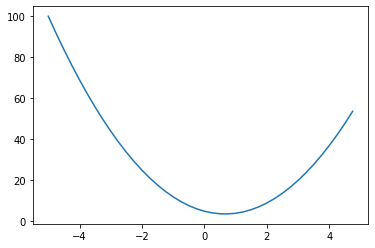

In [4]:
# creating a range of x values from -5 to 5 incrementing by 0.25 to pass into our function to generate our y values
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

We know want to think through what is the derivative of this function at different points x, let refresh with the definition of a derivative 
## $f'(x) = lim_{h \to 0} \frac{f(x+h)-f(x)}{h}$ 


You are basically trying to see the level of sensitivty the function responds with by bumping any x value at any point slightly by this small number h </br>
Intuitively how would you expect this function to respond if we nudged x = 3.0 by this small postitive number h? The amount the x value responds tells you the strength of the slope

In [5]:
h = 0.0001
x = 3.0
print(f'slope of function at x = {x}, slope = {(f(x + h) - f(x)) / h}')

slope of function at x = 3.0, slope = 14.000300000063248


Lets do a hacky implementation with more variables </br>
Look at the function a*b + c in relation to the variables we assigned, imagine if you nudged each variables by a tiny amount would that result in our output being increased or decreased? </br>
If we were to slightly nudge each of our input varibles by the tiny amount h(amount approaching 0) we can approximate the instataneous rate of change by looking at the difference before and after over the amount we nudged by, this will give us the slope.


In [6]:
# lets get more complex
h = 0.0001
#inputs
a = 2.0
b = -3.0
c = 10.0

#We wanna find the derivative of d with respect to a,b,c
d1 = a*b + c
a +=  h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


Lets do it with b now


In [7]:
d1 = a*b + c
b +=  h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 3.999699999999999
d2 3.99990001
slope 2.0001000000124947


And c...

In [8]:
d1 = a*b + c
c +=  h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 3.99990001
d2 4.00000001
slope 0.9999999999976694


Hopefully this has helped build an inuitive sense of what this derivative is telling you about the function, but now we want to move to neural networks, which will be massive mathmatical expressions, so we need some structures to maintain these expressions, so we will build out a value object that can keep track of state and allow us to do expressions  

<a id=2></a>
# Core Value Object

In [9]:
class Value:
    
    def __init__(self, data):
        self.data = data
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out
    
a = Value(2.0)
b = Value(-3.0)
a + b

a * b

Value(data=-6.0)

We use double underscore or dunder methods so python knows what to interally when we use operators such as print, +, -, * </br>
So when we call ```a + b``` above what is happening interally is ```a.__add__(b)``` with self as a and b as other. Similarly when we do ```a * b```, python is calling ```a.__mul__(b)``` 

Cool so now we can do basic arthmetic now we need to add pointers to what see values produce other values and by what operations

In [13]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out 
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

Now that we have the a way to store the parents, labels and operations we can visualize them with an expression graph, code below allows us to do that using a library called graphviz

In [16]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

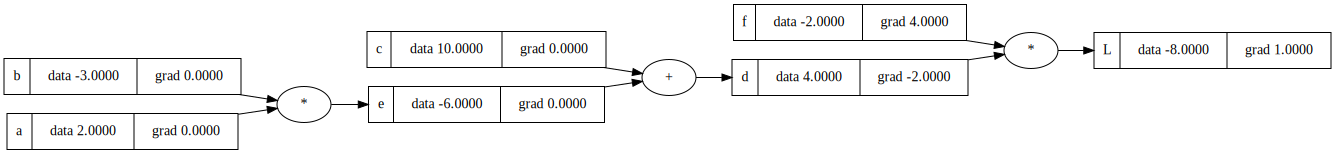

In [24]:
draw_dot(L)

Lets recap:
- we are able to build out mathematical expressions using + and *
- Added and tracked grad so we can calculate and update this state later when we do backpropagtion
- Forward pass that produces output L and visualized
- Now we want to do backpropagation

<a id=3></a>
# Manual Backpropagation

Lets manually nudge the variable a and manually calculate the derivative of L with respect to a, lets create a gating function lol so we don't pollute the global scope. We can do this for each variable to calculate their derivative with respect to L

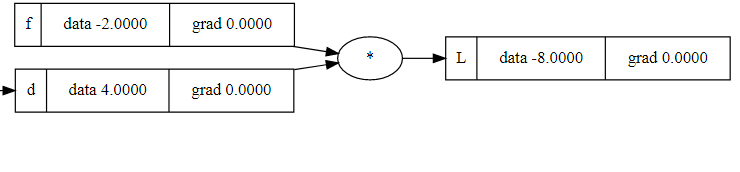

### $L = d * f$
### $\frac{dL}{dd} =? f$
### $lim_{h \to 0} \frac{(d+h)*f - d*f}{h}$ 
### $lim_{h \to 0} \frac{d*f + h*f - d*f}{h}$ 
### $lim_{h \to 0} \frac{h*f}{h}$ 
### $f$ 
So we can see that f.grad is just the value of d which is 4.0 and d.grad is just the value of f which is -2.0, lets go ahead and manually set these

In [23]:
f.grad = 4.0
d.grad = -2.0

In [21]:
L.grad = 1

In [25]:
def lol():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    # this is the variable we are nudging by h
    a = Value(2.0 , label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    d.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2-L1)/h)
lol()

-1.9999999999953388


So we have just derived the derivates of f and d with respect to L in a step by step way, now next will uncover the core of backpropagation, we want derive the derivative of L with respect to c and e. </br>
We now know how L is sensitive to d and we know how e and c are sensitive to d, we can know put that together to figure out how L is sensitive to e and c.

### If a variable z depends on the variable y, which itself depends on the variable x (that is, y and z are dependent variables), then z depends on x as well, via the intermediate variable y. In this case, the chain rule is expressed as
# $\frac{dz}{dx} = \frac{dz}{dy} * \frac{dy}{dx}$
The chain rule is fundamentally telling you how we chain these derivatives together correctly so to differentiate through a function composition we have to apply a multiplication of those derivatives </br>
```The inuitive explanation here is that knowing the instantaneous rate of change of z with respect to y and y relative to x allows one to calculate the instantaneous rate of change of z```

### If a car travels twice as fast as a bicyle and the cycle is four times as fast as a walking man then the car is 2 * 4 = 8 times faster than the man